# Analyse de série temporelle de température

Ce notebook charge des mesures horaires de température, effectue un prétraitement (rééchantillonnage, création de retards), puis évalue différents modèles de régression (linéaire, forêt aléatoire) et ARIMA/SARIMA.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import itertools
from math import sqrt
from sklearn.utils import Bunch
# from copy import deepcopy
# une copie est parfois nécessaire, pour pouvoir modifier une copie sans modifier l'autre.
# Ce module met à disposition des opérations de copie génériques superficielle et récursive

%matplotlib inline
# La commande "%matplotlib" configure la bibliothèque que vous allez utiliser pour dessiner le graphique.
# Elle effectue donc un certain nombre de traitements pour préparer l'affichage du graphique.
# Elle est souvent utilisée avec l'argument "inline", qui indique que l'on va utiliser la bibliothèque intégrée à Notebook.
pd.options.display.float_format = "{:.2f}".format
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (25, 5)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')


## 1. Chargement et préparation des données
- Lecture du CSV open-meteo
- Conversion de la colonne temps en datetime et utilisation comme index
- Tri chronologique et renommage de la colonne de température
- Vérification rapide des dimensions et des valeurs manquantes

In [38]:
# Lecture du fichier source
cv = pd.read_csv(
    "open-meteo.csv",
    skiprows=3,          # ignore les métadonnées
    delimiter=","      # séparateur CSV
)

# Préparation de l'index temporel
cv["time"] = pd.to_datetime(cv["time"])  # conversion datetime
cv = cv.set_index("time")                 # index temporel
cv.sort_index(inplace=True)

# Renommage de la colonne principale
cv = cv.rename(columns={
    "temperature_2m (°C)": "temperature_2m"
})

cv.head(10)  # aperçu des premières lignes

,temperature_2m
time,
2019-01-01 00:00:00,6.30
2019-01-01 01:00:00,6.60
2019-01-01 02:00:00,6.40
2019-01-01 03:00:00,6.30
2019-01-01 04:00:00,6.70
2019-01-01 05:00:00,6.90
2019-01-01 06:00:00,6.70
2019-01-01 07:00:00,6.50
2019-01-01 08:00:00,6.90


In [39]:
cv.shape

(35088, 1)

In [40]:
cv.isna().sum()

,0
temperature_2m,0


In [41]:
value_column = 'temperature_2m'

In [42]:
ts_data = cv[value_column]

## 2. Rééchantillonnage et exploration rapide
- Passage en pas de 3 heures pour lisser les mesures horaires
- Visualisation de l'évolution de la température
- Décomposition saisonnière pour inspecter tendance et saisonnalité

In [43]:
# Rééchantillonnage en pas de 3 heures (moyenne)
df_3h = ts_data.resample("3H").mean().reset_index()
df_3h.head()

,time,temperature_2m
0,2019-01-01 00:00:00,6.43
1,2019-01-01 03:00:00,6.63
2,2019-01-01 06:00:00,6.70
3,2019-01-01 09:00:00,8.00
4,2019-01-01 12:00:00,8.63


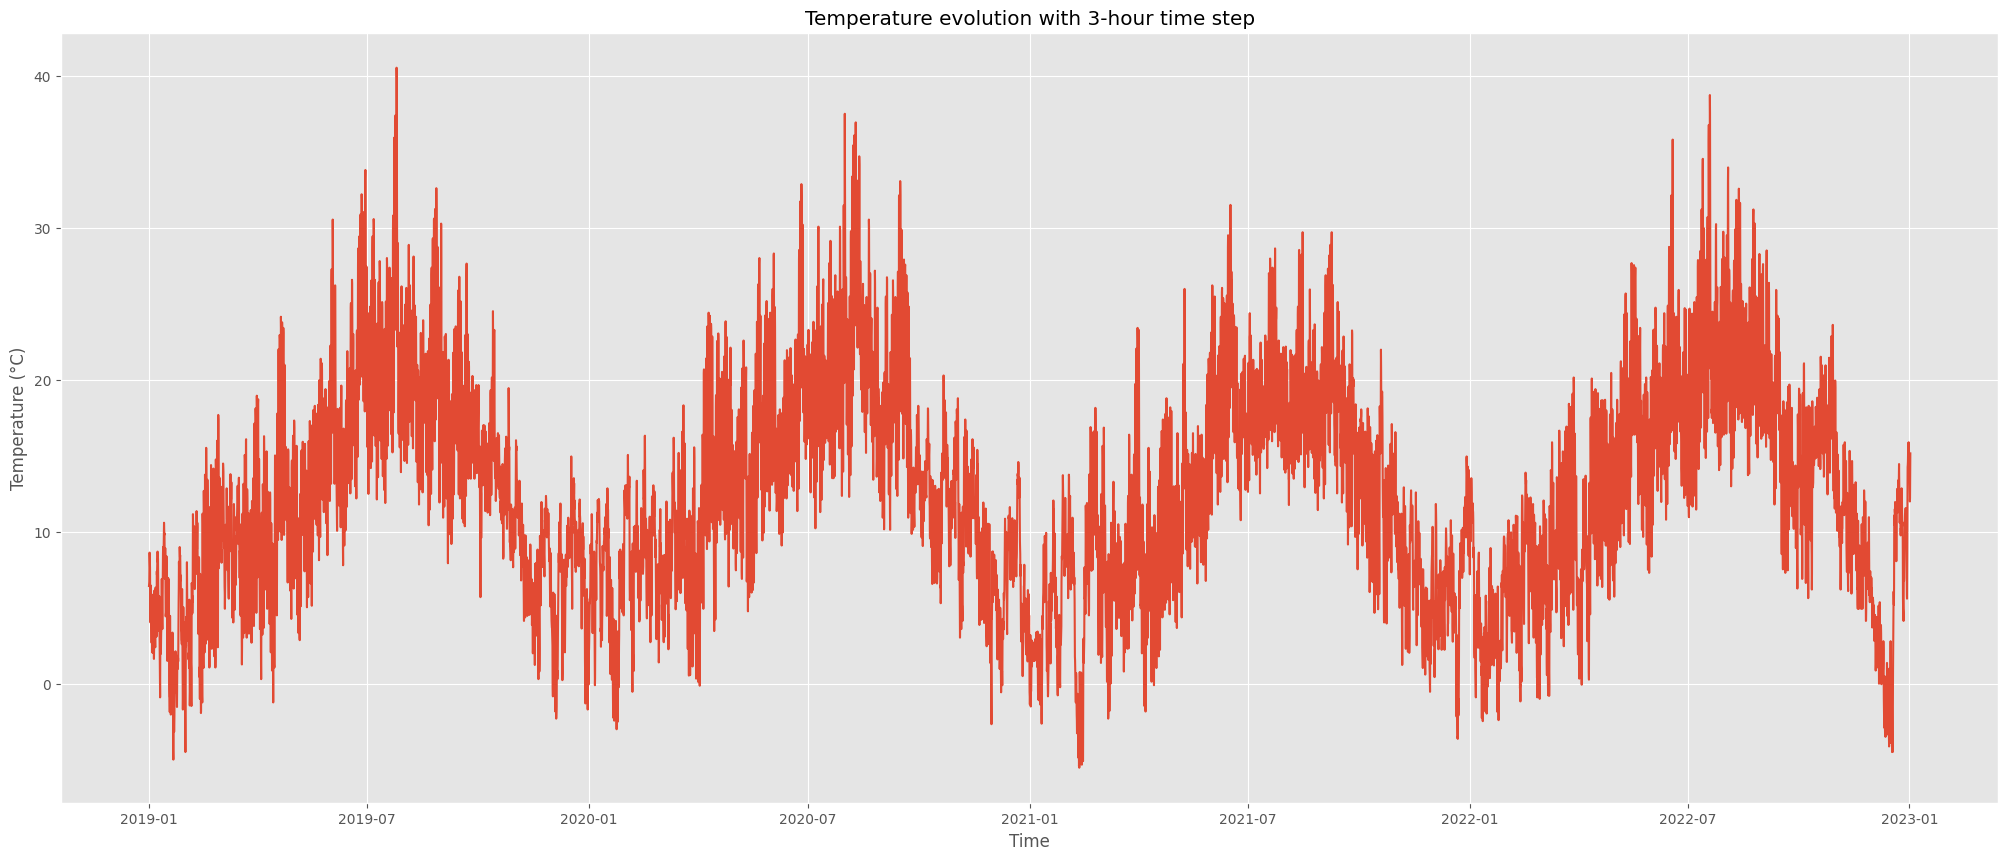

In [44]:
plt.figure(figsize=(25,10))
plt.plot(df_3h["time"], df_3h["temperature_2m"])
plt.title("Temperature evolution with 3-hour time step")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.show()

In [45]:
# Statistiques de stationnarité (ADF et KPSS)
from statsmodels.tsa.stattools import adfuller, kpss

ts_3h = df_3h.set_index("time")["temperature_2m"]

adf_test = adfuller(ts_3h)
print('ADF Test Results:')
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values: {adf_test[4]}')

kpss_test = kpss(ts_3h)
print('\nKPSS Test Results:')
print(f'KPSS Statistic: {kpss_test[0]}')
print(f'p-value: {kpss_test[1]}')
print(f'Critical Values: {kpss_test[3]}')

ADF Test Results:
ADF Statistic: -4.980106467880086
p-value: 2.4295542165312147e-05
Critical Values: {'1%': np.float64(-3.4309111961239807), '5%': np.float64(-2.8617880191825247), '10%': np.float64(-2.566902015530883)}

KPSS Test Results:
KPSS Statistic: 0.3126872242249915
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


## 3. Création de variables de retard et découpage temporel
- Génération de 8 retards (lags) pour capturer la dépendance temporelle
- Nettoyage des valeurs manquantes induites par les décalages
- Découpage train / validation / test selon des bornes temporelles

In [46]:
def make_lags(nb_lags, df, value_column):
    for lag in range(1, nb_lags + 1):
        df[f'{value_column}_lag_{lag}'] = df[value_column].shift(lag)

In [47]:
ts_df = ts_3h.to_frame(name=value_column)

In [48]:
make_lags(7, ts_df, value_column)
ts_df.dropna(inplace=True)
ts_df.shape

(11689, 8)

In [49]:
print(f"Début des données: {ts_df.index.min()}")
print(f"Fin des données: {ts_df.index.max()}")
print(f"Durée totale: {(ts_df.index.max() - ts_df.index.min()).days} jours")

Début des données: 2019-01-01 21:00:00
Fin des données: 2023-01-01 21:00:00
Durée totale: 1461 jours


In [50]:
train_end = '2021-09-30'    # ~70% des données
val_end = '2022-04-30'      # ~15% des données

## 4. Modèles de régression (baselines)
- Régression linéaire sur les retards
- Forêt aléatoire sur les mêmes variables
- Visualisation des coefficients/importances

In [51]:
# Découpage temporel en trois ensembles
train = ts_df.loc[:'2021-09-30']
val = ts_df.loc['2021-10-01':'2022-04-30']
test = ts_df.loc['2022-05-01':]

print("="*70)
print("SPLIT DES DONNÉES - SÉRIE TEMPORELLE")
print("="*70)
print(f"\n📊 PÉRIODE TOTALE")
print(f"   Du {ts_df.index.min()} au {ts_df.index.max()}")
print(f"   Durée: 1454 jours ({len(ts_df)} observations avec pas de 3h)")

print(f"\n🎯 TRAIN")
print(f"   Période: {train.index.min()} à {train.index.max()}")
print(f"   Durée: {(train.index.max() - train.index.min()).days} jours")
print(f"   Taille: {len(train)} observations ({len(train)/len(ts_df)*100:.1f}%)")

print(f"\n🔧 VALIDATION")
print(f"   Période: {val.index.min()} à {val.index.max()}")
print(f"   Durée: {(val.index.max() - val.index.min()).days} jours")
print(f"   Taille: {len(val)} observations ({len(val)/len(ts_df)*100:.1f}%)")

print(f"\n🧪 TEST")
print(f"   Période: {test.index.min()} à {test.index.max()}")
print(f"   Durée: {(test.index.max() - test.index.min()).days} jours")
print(f"   Taille: {len(test)} observations ({len(test)/len(ts_df)*100:.1f}%)")

print("="*70)

SPLIT DES DONNÉES - SÉRIE TEMPORELLE

📊 PÉRIODE TOTALE
   Du 2019-01-01 21:00:00 au 2023-01-01 21:00:00
   Durée: 1454 jours (11689 observations avec pas de 3h)

🎯 TRAIN
   Période: 2019-01-01 21:00:00 à 2021-09-30 21:00:00
   Durée: 1003 jours
   Taille: 8025 observations (68.7%)

🔧 VALIDATION
   Période: 2021-10-01 00:00:00 à 2022-04-30 21:00:00
   Durée: 211 jours
   Taille: 1696 observations (14.5%)

🧪 TEST
   Période: 2022-05-01 00:00:00 à 2023-01-01 21:00:00
   Durée: 245 jours
   Taille: 1968 observations (16.8%)


In [52]:
X_train = train.drop(columns=[value_column])
y_train = train[value_column]

# VAL
X_val = val.drop(columns=[value_column])
y_val = val[value_column]

# TEST
X_test = test.drop(columns=[value_column])
y_test = test[value_column]

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Modèle linéaire simple sur les lags
model = LinearRegression()
X_train_num = X_train.select_dtypes(include=np.number)
X_val_num = X_val.select_dtypes(include=np.number)
model.fit(X_train_num, y_train)  # apprentissage

y_pred = model.predict(X_val_num)  # prédictions validation
r2 = r2_score(y_val, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.9066475123153149


In [54]:
# Feature Importances (coefficients)
coefficients = model.coef_
feature_names = X_train_num.columns

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'absolute_importance': np.abs(coefficients)
}).sort_values(by='absolute_importance', ascending=False)

print("\nLinear Regression Coefficients (triés par importance):")
print(coef_df)


Linear Regression Coefficients (triés par importance):
                feature  coefficient  absolute_importance
0  temperature_2m_lag_1         1.21                 1.21
1  temperature_2m_lag_2        -0.65                 0.65
6  temperature_2m_lag_7         0.28                 0.28
2  temperature_2m_lag_3         0.17                 0.17
3  temperature_2m_lag_4        -0.09                 0.09
4  temperature_2m_lag_5         0.08                 0.08
5  temperature_2m_lag_6        -0.01                 0.01


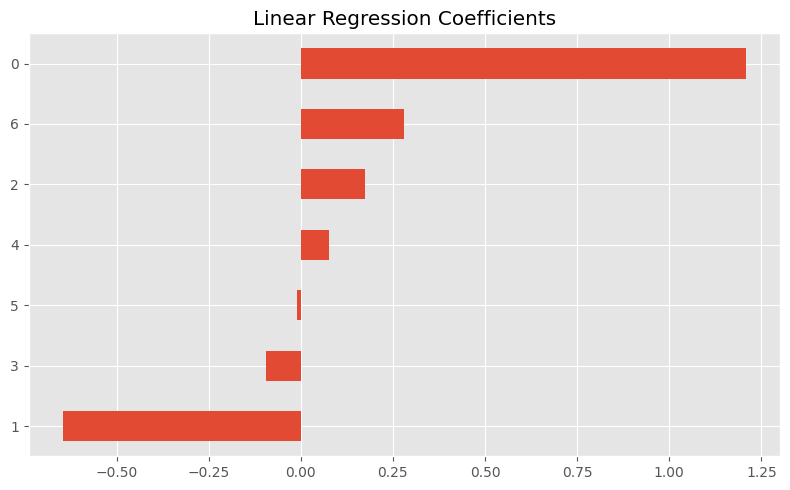

In [55]:
coef_df.sort_values(by='coefficient')['coefficient'].plot(kind='barh', figsize=(8,5))
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor()
X_train_num = X_train.select_dtypes(include=np.number)
rf_model.fit(X_train_num, y_train)

# Make predictions
X_val_num = X_val.select_dtypes(include=np.number)
y_pred_rf = rf_model.predict(X_val_num)

# Evaluate the model
mse_rf = mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

Random Forest Mean Squared Error: 1.7169672874737942
Random Forest R-squared: 0.9172584893482266


In [57]:
importances = rf_model.feature_importances_

feature_names = X_train_num.columns

# Create a sorted DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                feature  importance
0  temperature_2m_lag_1        0.88
6  temperature_2m_lag_7        0.08
1  temperature_2m_lag_2        0.01
2  temperature_2m_lag_3        0.01
5  temperature_2m_lag_6        0.01
3  temperature_2m_lag_4        0.01
4  temperature_2m_lag_5        0.01


## 5. Modèles ARIMA / SARIMA
- Recherche d'ordre (p, d, q) non saisonnier via grille simple
- Sélection sur AIC / RMSE sur le jeu de validation
- Exploration ensuite des composantes saisonnières (P, D, Q, s)

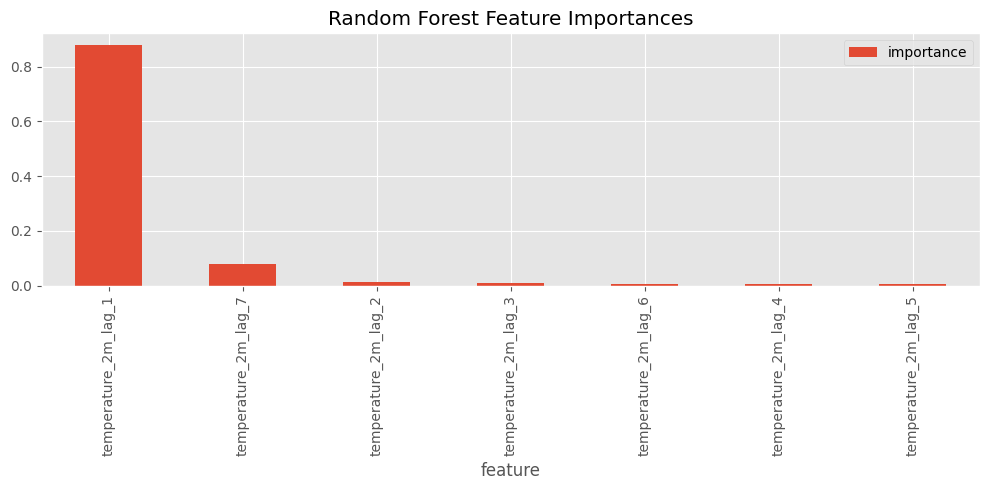

In [58]:
importance_df.plot(kind='bar', x='feature', y='importance', figsize=(10,5))
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import Bunch
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

# fonction qui fitte un modèle sur le jeu test et renvoie ses critères d'évaluation pour le jeu de validation
# pour des valeurs données de p d et q paramètres NON SAISONNIERS
# modèle ARIMA
def evaluate_arima(params, ts_train, ts_val):
  p, d, q = params
  order = (p, d, q)
  try:
    # fitter le modèle sur le jeu test
    model = SARIMAX(ts_train, order=order).fit()
    #print(model.aic)
    # evaluer les predictions de ce modèle sur le jeu validation
    ts_pred = model.predict(start=ts_val.index[0], end=ts_val.index[-1])
    # comme la série temporelle a été log transformée, le RMSE correspond au RMSLE pour la série initiale
    rmlse = sqrt(mean_squared_error(ts_val, ts_pred))
    r2 = r2_score(ts_val, ts_pred)
    scores = Bunch(aic=model.aic, rmsle=rmlse, r2=r2)
    #print(model.aic)
    return (params, scores)
  except Exception as e:
    scores = Bunch(aic=float("inf"), rmsle=float("inf"), r2=float("-inf"))
    return (params, scores)

In [60]:
# Définir les plages de p et q à tester
p_values = range(0, 6)
q_values = range(0, 6)
d = 0  # stationnaire

# Stocker tous les résultats
results = []

# Boucle sur toutes les combinaisons
for p, q in itertools.product(p_values, q_values):
    params, scores = evaluate_arima((p, d, q), y_train, y_val)
    results.append({
        'p': p,
        'd': d,
        'q': q,
        'AIC': scores.aic,
        'RMSLE': scores.rmsle,
        'R2': scores.r2
    })

# Convertir en DataFrame et trier par AIC
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

print("Top 5 modèles ARIMA selon AIC :")
print(results_df.head(5))


Top 5 modèles ARIMA selon AIC :
   p  d  q      AIC  RMSLE    R2
0  5  0  5 25576.25   6.11 -0.80
1  4  0  5 26357.25   6.54 -1.06
2  5  0  3 26588.11   5.86 -0.65
3  5  0  2 26596.81   6.65 -1.13
4  3  0  5 26660.78   6.21 -0.86


In [66]:
import statsmodels.api as sm

p = 5
d = 0
q = 3
model = sm.tsa.ARIMA(y_train, order=(p,d,q))

res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                 8025
Model:                 ARIMA(5, 0, 3)   Log Likelihood              -13273.117
Date:                Mon, 15 Dec 2025   AIC                          26566.234
Time:                        13:59:40   BIC                          26636.137
Sample:                    01-01-2019   HQIC                         26590.157
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8165      1.675      7.650      0.000       9.533      16.100
ar.L1          2.4748      0.030     83.226      0.000       2.417       2.533
ar.L2         -2.9421      0.074    -39.698      0.0

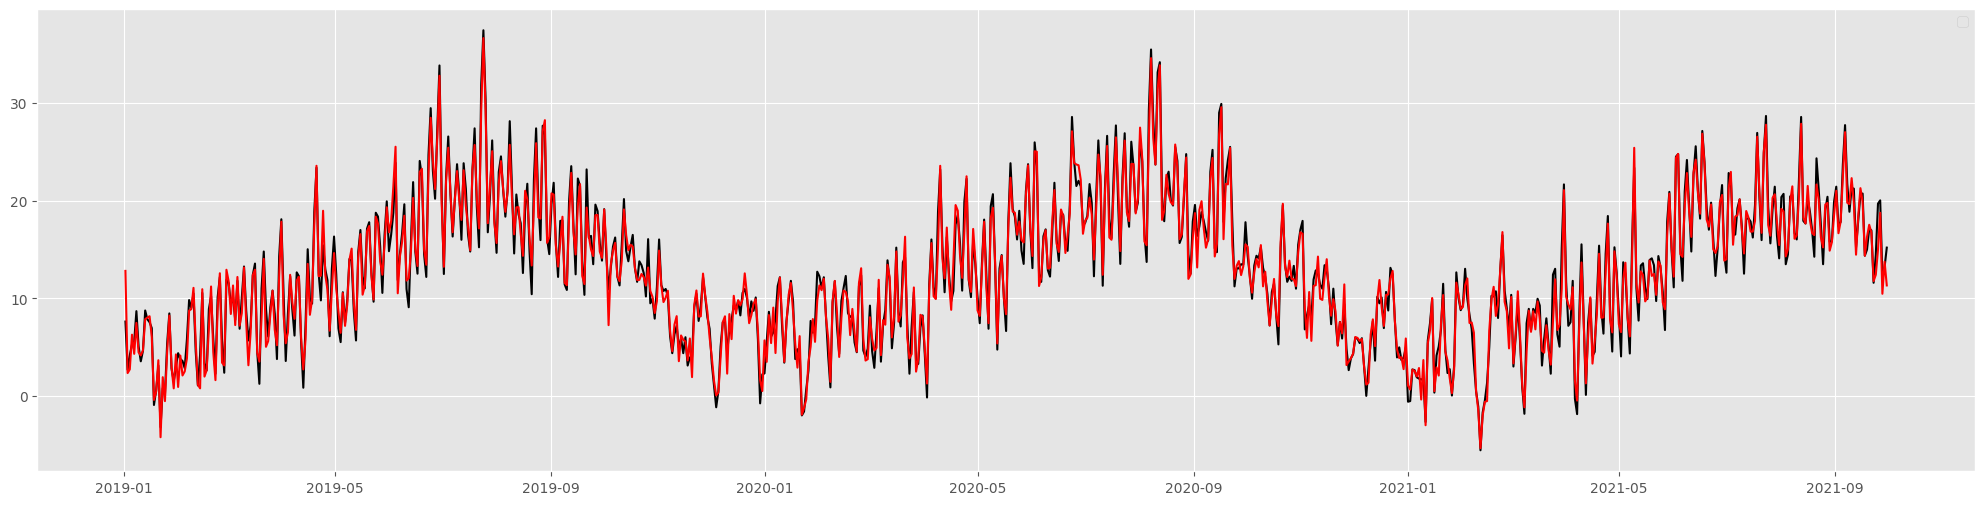

In [67]:
step = 10
plt.figure(figsize=(25, 6))
plt.plot(y_train[d::step], color='black')
plt.plot(res.fittedvalues[d::step], color='red')
plt.legend()
plt.show()


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_sarimax(params, seasonal_params, ts_train, ts_val):
    p, d, q = params
    P, D, Q, s = seasonal_params

    try:
        model = SARIMAX(ts_train, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False,enforce_invertibility=False )
        results = model.fit(disp=False)

    # Prévision
        forecast = results.forecast(steps=len(ts_val))
        rmse = np.sqrt(mean_squared_error(ts_val, forecast))
        aic = results.aic

        return results, aic, rmse
    except Exception as e:
        print(f"❌ Erreur pour SARIMA({p},{d},{q}) x ({P},{D},{Q},{s}) → {e}")
        return None, np.inf, np.inf

In [71]:
from itertools import product
best_arima_params = (5, 0, 3)

# Paramètres saisonniers à tester
P_params = range(1, 6) # SAR
Q_params = range(1, 6) # SMA
D_params = [0] # Diff saisonnière
s_param = 8 # saisonnalité mensuelle

seasonal_combos = list(product(P_params, D_params, Q_params))

In [72]:
# Meilleurs paramètres ARIMA (non saisonniers) — choisis l'un des deux


print(f"🔁 Test de {len(seasonal_combos)} combinaisons saisonnières avec params ARIMA {best_arima_params}")

#Variables de suivi
best_aic = np.inf
best_rmse = np.inf
best_params_aic = None
best_params_rmse = None

results_list = []

#Recherche uniquement sur la partie saisonnière
for seasonal in tqdm(seasonal_combos, desc = "recherche"):
    seasonal_params = (*seasonal, s_param)
    results, aic, rmse = evaluate_sarimax(best_arima_params, seasonal_params, y_train, y_val)

    results_list.append((best_arima_params, seasonal, aic, rmse))

    if aic < best_aic:
        best_aic = aic
        best_params_aic = (best_arima_params, seasonal)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params_rmse = (best_arima_params, seasonal)
    #Résultats finaux
print("\n🏆 Meilleur AIC avec ARIMA fixe 😊")
print(f" SARIMA{best_params_aic[0]} x {best_params_aic[1]} → AIC = {best_aic:.3f}")

print("\n🏆 Meilleur RMSE avec ARIMA fixe 😊")
print(f" SARIMA{best_params_rmse[0]} x {best_params_rmse[1]} → RMSE = {best_rmse:.2f}")

🔁 Test de 25 combinaisons saisonnières avec params ARIMA (5, 0, 3)


recherche: 100%|██████████| 25/25 [28:33<00:00, 68.53s/it] 


🏆 Meilleur AIC avec ARIMA fixe 😊
 SARIMA(5, 0, 3) x (2, 0, 5) → AIC = 23400.915

🏆 Meilleur RMSE avec ARIMA fixe 😊
 SARIMA(5, 0, 3) x (1, 0, 1) → RMSE = 5.04
